# DensNet 안면 Multi-Label (성별/나이) Classification

* val_acc, val_loss 과적합
* Epoch 20, patience=2, L2(0.01) 규제추가

In [31]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

### 데이터프레임 로드

* Shuffle된 단일 DataFrame 기준으로 학습
* FamilyData_All(Final)_DF.csv 사용하면 됌

In [32]:
# df=pd.read_csv('data/FamilyData/All(Final)/FamilyData_All(Final)_DF.csv',index_col=0)
df=pd.read_csv('data/FamilyData/All(Final)/FamilyData_All(Final)_DF.csv',index_col=0)
df[:10]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
0,F0085_IND_M_50_45_01.JPG,0,1,0,0,0,0,0,1,0
1,F0877_IND_S2_8_0_02.JPG,1,0,1,0,0,0,0,0,0
2,F0850_IND_D2_9_-45_02.JPG,0,1,1,0,0,0,0,0,0
3,F0448_IND_D_34_45_04.JPG,0,1,0,0,0,1,0,0,0
4,F0179_IND_D_28_90_02.JPG,0,1,0,0,1,0,0,0,0
5,F0369_IND_S_17_0_01.JPG,1,0,0,1,0,0,0,0,0
6,F0419_IND_S_15_45_03.JPG,1,0,0,1,0,0,0,0,0
7,F0712_IND_F_42_90_02.JPG,1,0,0,0,0,0,1,0,0
8,F0857_IND_M_49_45_02.JPG,0,1,0,0,0,0,1,0,0
9,F0086_IND_S_17_-90_01.JPG,1,0,0,1,0,0,0,0,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43850 entries, 0 to 43849
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  43850 non-null  object
 1   M         43850 non-null  int64 
 2   F         43850 non-null  int64 
 3   0's       43850 non-null  int64 
 4   10's      43850 non-null  int64 
 5   20's      43850 non-null  int64 
 6   30's      43850 non-null  int64 
 7   40's      43850 non-null  int64 
 8   50's      43850 non-null  int64 
 9   60+       43850 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 3.7+ MB


In [34]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, random_state=777, test_size=0.2,shuffle=True)
train_df, val_df = train_test_split(train_df, random_state=777, test_size=0.2,shuffle=True)

len(train_df) , len(val_df), len(test_df)

(28064, 7016, 8770)

In [35]:
train_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
12641,F0172_IND_F_54_-45_02.JPG,1,0,0,0,0,0,0,1,0
31426,F0156_IND_D2_10_0_02.JPG,0,1,0,1,0,0,0,0,0
24020,F0716_IND_M_54_-90_01.JPG,0,1,0,0,0,0,0,1,0
39006,F0433_IND_D_17_0_01.JPG,0,1,0,1,0,0,0,0,0
19718,F0474_IND_M_43_0_05.JPG,0,1,0,0,0,0,1,0,0


In [36]:
val_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
25814,F0295_IND_F_44_90_02.JPG,1,0,0,0,0,0,1,0,0
35670,F0734_IND_D_10_-45_02.JPG,0,1,0,1,0,0,0,0,0
30702,F0492_IND_M_46_90_01.jpg,0,1,0,0,0,0,1,0,0
11591,F0537_IND_D3_17_0_01.jpg,0,1,0,1,0,0,0,0,0
10830,F0273_IND_D_17_0_01.JPG,0,1,0,1,0,0,0,0,0


In [37]:
test_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
19093,F0378_IND_S2_15_0_02.JPG,1,0,0,1,0,0,0,0,0
28729,F0290_IND_D2_14_-90_03.JPG,0,1,0,1,0,0,0,0,0
8603,F0868_IND_D_33_0_01.JPG,0,1,0,0,0,1,0,0,0
10186,F0179_IND_F_54_-45_03.JPG,1,0,0,0,0,0,0,1,0
23428,F0319_IND_S2_30_0_02.JPG,1,0,0,0,0,1,0,0,0


In [38]:
columns= list(df.columns)[1:]
columns

['M', 'F', "0's", "10's", "20's", "30's", "40's", "50's", '60+']

### ImageGenerator 정의

* 엘리베이터 상황 가정, 밝기/확대 다양히
* https://www.datasciencelearner.com/brightness_range-keras-data-augmentation/
* https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

In [39]:
# 밝기 : 0.3~1.0 (0은 검정색)
# zoom : 0.3 => 30퍼센트

datagen=ImageDataGenerator(rescale=1./255.,brightness_range=[0.3,1.0],zoom_range=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.,brightness_range=[0.3,1.0],zoom_range=0.3)

* batch_size=32 시 메모리 오류, 그 이하로 설정

In [40]:
preprocessed_data_path = 'D:/Preprocessed_Datasets(All)/'

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=16,
    seed=777,
    shuffle=True,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 28064 validated image filenames.


In [41]:
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=16,
    seed=777,
    shuffle=True,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 7016 validated image filenames.


In [42]:
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=16,
    seed=777,
    shuffle=False,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 8770 validated image filenames.


### 모델 정의

* 학습 속도 줄이고 싶을 시 : 일부 전이학습 모델 Layers 삭제

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras import regularizers

# 레이어 추가 시
# include_top = False 
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
output = model_d.output

x= GlobalAveragePooling2D()(output)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu',activity_regularizer=regularizers.L2(0.01))(x) 
x= Dense(512,activation='relu',activity_regularizer=regularizers.L2(0.01))(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(9,activation='sigmoid')(x) #FC-layer

In [44]:
model=Model(inputs=model_d.input,outputs=preds)
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

                                                                                                  
 conv2_block1_0_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 128)  8192        ['conv2_block1_0_relu[0][0]']    
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block1_1_bn[0][0]']      
 n)       

### GPU 확인

In [45]:
!nvidia-smi

Thu Jul 20 09:18:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P8              11W /  85W |   3823MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [46]:
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        print("gpus available")
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

gpus available
Physical devices cannot be modified after being initialized


### GPU 인식안될 시
### Anaconda Prompt(관리자 권한 실행) - pip uninstall tensorflow - pip install tensorflow==2.10

In [47]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12290640276346780619
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15707208184421988179
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [48]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [49]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [50]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [51]:
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

### 모델 학습

* 총 epochs =20 으로 설정
* EarlyStopping patience = 2~3 정도
* DenseNet 기준 1 epoch 당 1시간 

In [52]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('models/DensNet_best_model3.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

epochs = 20
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=valid_generator,
                        callbacks=[es, mc])

Epoch 1/20
1754/1754 [==============================] - 2317s 1s/step - loss: 0.5550 - acc: 0.5301 - val_loss: 0.7079 - val_acc: 0.5597
Epoch 2/20
1754/1754 [==============================] - 1917s 1s/step - loss: 0.4353 - acc: 0.5539 - val_loss: 497.8805 - val_acc: 0.4550
Epoch 3/20
1754/1754 [==============================] - 1933s 1s/step - loss: 0.4351 - acc: 0.5550 - val_loss: 102.0657 - val_acc: 0.5155
Epoch 3: early stopping


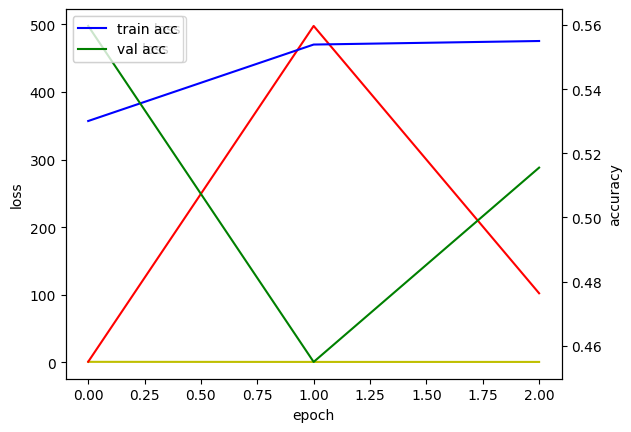

In [53]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

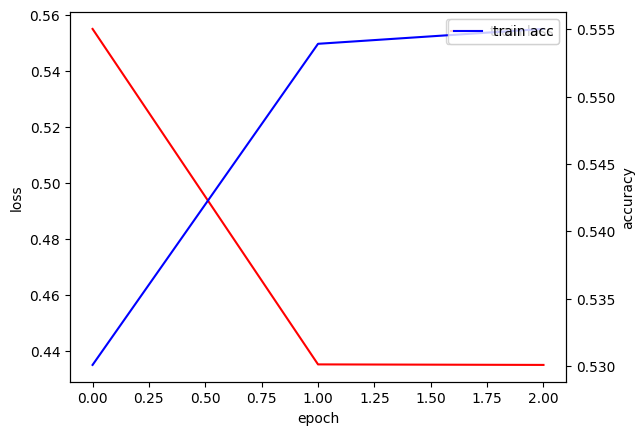

In [54]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'r', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend()

acc_ax.plot(history.history['acc'], 'b', label='train acc')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

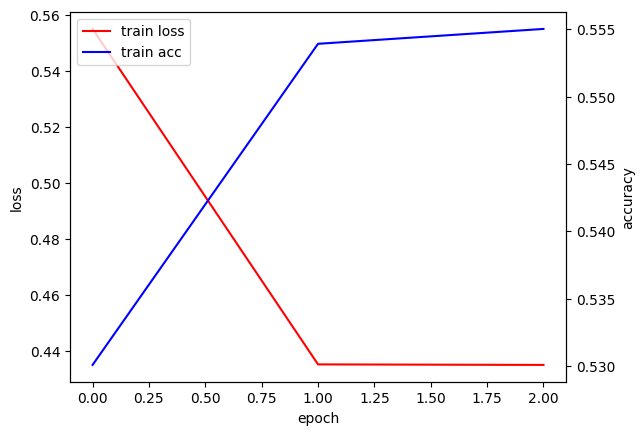

In [55]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'r', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')

# 범례 표시
loss_lines, loss_labels = loss_ax.get_legend_handles_labels()
acc_lines, acc_labels = acc_ax.get_legend_handles_labels()
lines = loss_lines + acc_lines
labels = loss_labels + acc_labels
loss_ax.legend(lines, labels, loc='upper left')

plt.show()

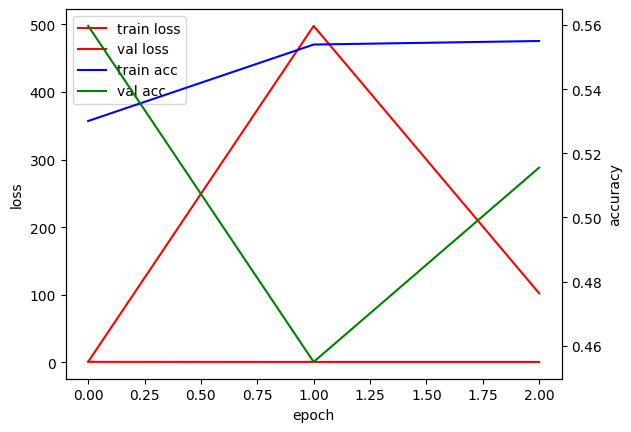

In [56]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'r', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')

# 범례 표시
loss_lines, loss_labels = loss_ax.get_legend_handles_labels()
acc_lines, acc_labels = acc_ax.get_legend_handles_labels()
lines = loss_lines + acc_lines
labels = loss_labels + acc_labels
loss_ax.legend(lines, labels, loc='upper left')

plt.show()

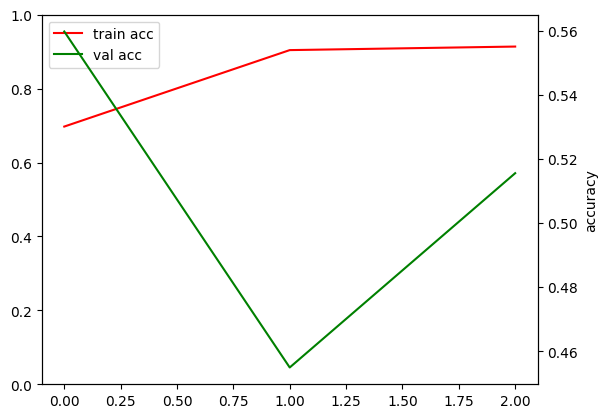

In [57]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'r', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['acc'], 'r', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')

# 범례 표시
loss_lines, loss_labels = loss_ax.get_legend_handles_labels()
acc_lines, acc_labels = acc_ax.get_legend_handles_labels()
lines = loss_lines + acc_lines
labels = loss_labels + acc_labels
loss_ax.legend(lines, labels, loc='upper left')

plt.show()

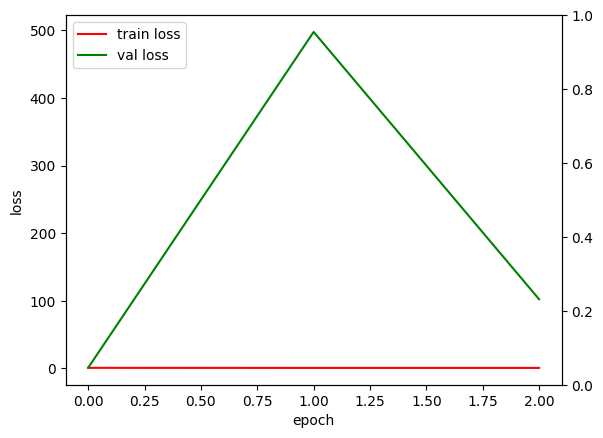

In [58]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'r', label='train loss')
loss_ax.plot(history.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

# acc_ax.plot(history.history['acc'], 'b', label='train acc')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
# acc_ax.set_ylabel('accuracy')

# 범례 표시
loss_lines, loss_labels = loss_ax.get_legend_handles_labels()
acc_lines, acc_labels = acc_ax.get_legend_handles_labels()
lines = loss_lines + acc_lines
labels = loss_labels + acc_labels
loss_ax.legend(lines, labels, loc='upper left')

plt.show()

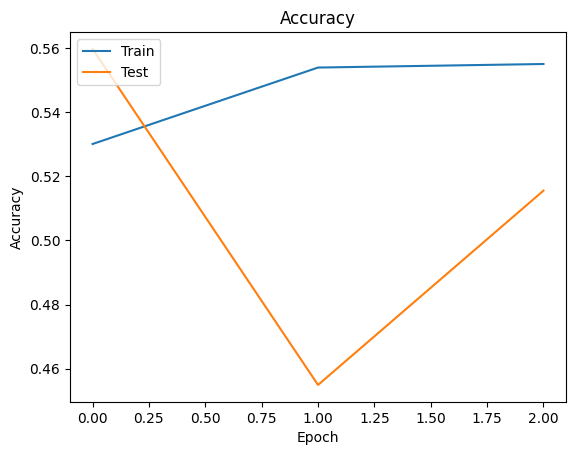

In [59]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

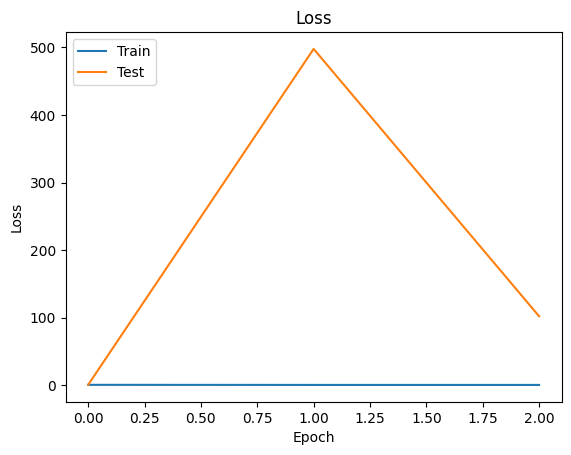

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 모델 평가

In [61]:
model.evaluate(test_generator)

549/549 [==============================] - 480s 875ms/step - loss: 89.3688 - acc: 0.5196


[89.3687515258789, 0.5196123123168945]

In [62]:
pred=model.predict(test_generator)
pred[0].round(3)

549/549 [==============================] - 421s 764ms/step


array([0.457, 0.542, 0.016, 0.389, 0.126, 0.054, 0.199, 0.108, 0.12 ],
      dtype=float32)

In [63]:
pred[0].argsort()[::-1]

array([1, 0, 3, 6, 4, 8, 7, 5, 2], dtype=int64)